<a href="https://colab.research.google.com/github/prabhanjanbhat/ISL/blob/main/Training_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip uninstall -y mediapipe


Found existing installation: mediapipe 0.10.21
Uninstalling mediapipe-0.10.21:
  Successfully uninstalled mediapipe-0.10.21


In [8]:
!pip install mediapipe


  Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl (35.6 MB)


In [9]:
!pip install opencv-python numpy tensorflow scikit-learn --quiet

import os
import cv2
import numpy as np
import mediapipe as mp
from glob import glob
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


NameError: name 'audio_classifier' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def extract_frames(video_path, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_path, frame)
        frame_count += 1

    cap.release()

# Extract frames for all videos in Dataset
dataset_path = "/content/drive/MyDrive/Include"
for class_name in os.listdir(dataset_path):  # e.g., Loud, Quiet
    if class_name.startswith("."):
        continue
    class_folder = os.path.join(dataset_path, class_name)
    for video_file in os.listdir(class_folder):
        if video_file.startswith("."):
            continue
        video_path = os.path.join(class_folder, video_file)
        frames_folder = f"{video_path}_frames"
        extract_frames(video_path, frames_folder)

print("Frame extraction completed.")


Frame extraction completed.


In [ ]:
mp_hands = mp.solutions.hands

def extract_hand_features_from_image(image):
    """Extract 63 (21 x 3) hand landmark features from a single image array."""
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1) as hands:
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_hand_landmarks:
            landmarks = results.multi_hand_landmarks[0]
            return np.array([[lm.x, lm.y, lm.z] for lm in landmarks.landmark]).flatten()
    return np.zeros(63)  # Return zero-vector if no hand is detected


In [ ]:
import random

def augment_frame(frame):
    """Apply random transformations to increase data variety."""
    # 1. Random horizontal flip (50% chance)
    if np.random.rand() < 0.5:
        frame = cv2.flip(frame, 1)
    # 2. Random brightness
    factor = 0.5 + np.random.rand()  # brightness factor between 0.5 and 1.5
    frame = cv2.convertScaleAbs(frame, alpha=factor, beta=0)
    # 3. Random rotation (-10 to 10 degrees)
    angle = random.uniform(-10, 10)
    h, w = frame.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
    frame = cv2.warpAffine(frame, M, (w, h))
    return frame


In [ ]:
def build_dataset(dataset_path, window_size=30, step_size=15):
    X_data, y_data = [], []

    for class_name in os.listdir(dataset_path):
        if class_name.startswith("."):
            continue
        class_folder = os.path.join(dataset_path, class_name)

        for video_file in os.listdir(class_folder):
            if video_file.startswith("."):
                continue

            frames_folder = f"{os.path.join(class_folder, video_file)}_frames"
            all_frames = sorted(glob(f"{frames_folder}/*.jpg"))

            # Skip if no frames extracted
            if len(all_frames) == 0:
                continue

            # Create sliding windows
            for start in range(0, len(all_frames) - window_size + 1, step_size):
                subseq_frames = all_frames[start : start + window_size]

                # Extract features for original subsequence
                subseq_features = []
                for frame_path in subseq_frames:
                    frame = cv2.imread(frame_path)
                    features = extract_hand_features_from_image(frame)
                    subseq_features.append(features)

                # Convert to np array shape (window_size, 63)
                subseq_features = np.array(subseq_features)

                # Add to dataset if we have the correct shape
                if subseq_features.shape == (window_size, 63):
                    X_data.append(subseq_features)
                    y_data.append(class_name)

                # Augment the subsequence
                aug_subseq_features = []
                for frame_path in subseq_frames:
                    frame = cv2.imread(frame_path)
                    # Apply augmentation
                    aug_frame = augment_frame(frame)
                    features = extract_hand_features_from_image(aug_frame)
                    aug_subseq_features.append(features)

                aug_subseq_features = np.array(aug_subseq_features)
                if aug_subseq_features.shape == (window_size, 63):
                    X_data.append(aug_subseq_features)
                    y_data.append(class_name)

    X_data = np.array(X_data)
    y_data = np.array(y_data)
    return X_data, y_data

# Build dataset
X, y = build_dataset(dataset_path="/content/drive/MyDrive/Include", window_size=30, step_size=15)

print("X.shape:", X.shape)  # (num_samples, 30, 63)
print("y.shape:", y.shape)  # (num_samples,)


X.shape: (206, 30, 63)
y.shape: (206,)


In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Classes found:", label_encoder.classes_)

unique, counts = np.unique(y_encoded, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

# One-hot encoding if using 'categorical_crossentropy'
y_one_hot = to_categorical(y_encoded)


Classes found: ['Loud' 'Quiet']
Class distribution: {0: 98, 1: 108}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128, return_sequences=True, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    LSTM(256, return_sequences=True, activation='relu'),
    Dropout(0.3),
    LSTM(128, return_sequences=False, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_one_hot.shape[1], activation='softmax')  # number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y_one_hot, epochs=50, batch_size=8, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.6388 - loss: 1.2595 - val_accuracy: 0.0000e+00 - val_loss: 3.1646
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.6328 - loss: 0.6156 - val_accuracy: 0.0000e+00 - val_loss: 1.6230
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.7771 - loss: 0.5377 - val_accuracy: 1.0000 - val_loss: 0.5387
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.4203 - loss: 0.6521 - val_accuracy: 0.1905 - val_loss: 0.7060
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7401 - loss: 0.5732 - val_accuracy: 0.0476 - val_loss: 0.9170
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.8498 - loss: 0.4560 - val_accuracy: 0.0000e+00 - val_loss: 1.6567
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.8667 - loss: 0.4149 - val_accuracy: 0.5952 - val_loss: 0.6447
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.6503 - loss: 0.5748 - val

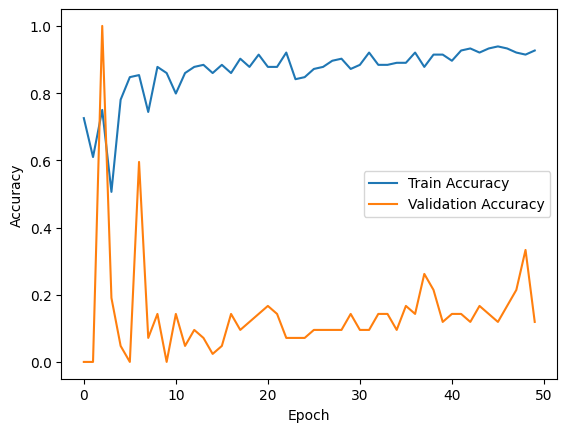

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8942 - loss: 0.3005
Final Training Accuracy: 0.78


In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Final evaluation on training data (or a separate test set if you have one)
loss, acc = model.evaluate(X, y_one_hot)
print(f"Final Training Accuracy: {acc:.2f}")


In [ ]:
def predict_sign_for_new_video(video_path):
    # 1. Extract frames
    frames_folder = f"{video_path}_frames"
    extract_frames(video_path, frames_folder)

    # 2. Build subsequences (without augmentation, for inference)
    all_frames = sorted(glob(f"{frames_folder}/*.jpg"))
    window_size = 30
    step_size = 15

    predictions = []

    for start in range(0, len(all_frames) - window_size + 1, step_size):
        subseq_frames = all_frames[start : start + window_size]
        subseq_features = []
        for frame_path in subseq_frames:
            frame = cv2.imread(frame_path)
            feat = extract_hand_features_from_image(frame)
            subseq_features.append(feat)

        subseq_features = np.array(subseq_features)
        if subseq_features.shape == (window_size, 63):
            subseq_features = subseq_features.reshape(1, window_size, 63)
            y_pred = model.predict(subseq_features)
            predictions.append(y_pred[0])  # shape (num_classes,)

    if not predictions:
        print("No valid subsequences found.")
        return

    # Average all subsequence predictions
    avg_pred = np.mean(predictions, axis=0)  # shape (num_classes,)
    pred_index = np.argmax(avg_pred)
    pred_label = label_encoder.inverse_transform([pred_index])[0]
    print(f"Predicted sign: {pred_label}")





In [ ]:
from google.colab import files

uploaded = files.upload()


Saving Loud.mov to Loud.mov


In [ ]:
predict_sign_for_new_video("/content/WhatsApp Video 2025-03-12 at 21.45.42.mov")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted sign: Quiet


In [ ]:
predict_sign_for_new_video("/content/WhatsApp Video 2025-03-12 at 21.53.22 (1).mov")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted sign: Loud


In [ ]:
model.save("my_sign_model_using_LSTM.h5")


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("/content/my_sign_model_using_LSTM.h5")


In [ ]:
predict_sign_for_new_video("/content/WhatsApp Video 2025-03-12 at 21.45.42.mov")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted sign: Quiet


In [ ]:
predict_sign_for_new_video("/content/Loud.mov")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted sign: Loud


In [ ]:
import pickle

# Save
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# Load
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)
